---
title: "Digital Waveguide Models"
author: "Brian Cruz"
date: "2025-12-06"
categories: sound synthesis, mathematics
---


::: {.content-hidden}
# HIDDEN: Frontend mattter
:::

In [1]:
# | echo: false
# | output: false

# We want to initialize Plotly's notebook mode so that it is rendered properly in Quarto.
# Otherwise, we may see the message
#   Unable to display output for mime type(s): application/vnd.plotly.v1+json

import plotly.offline as py

py.init_notebook_mode(connected=True)


::: {.content-hidden}
# HIDDEN: Article START
:::

Digital waveguide models are a powerful technique for simulating the behavior of vibrating strings and other wave-propagating systems in a computationally efficient manner.

The 1-dimensional wave equation describes how waves propagate along a string. In a digital waveguide model, we discretize this equation to create a system of delay lines and filters that simulate the wave's travel along the string. The delay lines represent the time it takes for waves to travel back and forth along the string, while the filters model the physical properties of the string, such as stiffness and damping.

By adjusting the parameters of the delay lines and filters, we can simulate different types of strings and their behaviors, allowing for realistic sound synthesis in musical applications.

The 1D wave equation is given by:

$$\frac{\partial^2 y(x,t)}{\partial t^2} = c^2 \frac{\partial^2 y(x,t)}{\partial x^2}$$
where $y(x,t)$ is the displacement of the string at position $x$ and time $t$, and $c$ is the wave speed on the string.

In this notebook we'll use a 4th order Runge-Kutta method to numerically solve the wave equation and simulate the behavior of a vibrating string.

We'll use the following sets of initial conditions:
- Plucked string:
    - Initial displacement: A plucked string shape, such as a triangular or Gaussian profile.
    - Initial velocity: Zero initial velocity, meaning the string starts from rest.
- Struck string:
    - Initial displacement: Zero initial displacement, meaning the string starts at rest.
    - Initial velocity: A localized velocity profile, such as a Gaussian or rectangular shape, representing the impact of a hammer strike.

In [2]:
# Create a dataclass for the initial conditions of the waveguide

from dataclasses import dataclass
import numpy as np


@dataclass
class WaveguideStates:
    positions: np.ndarray
    velocities: np.ndarray
    time: float = 0.0
    linear_density: float = 0.01  # kg/m
    tension: float = 100.0  # N

    def __init__(
        self,
        positions: np.ndarray,
        velocities: np.ndarray,
        time: float = 0.0,
    ):
        # If positions and velocities are 1D arrays, convert them to 2D column vectors
        if positions.ndim == 1:
            positions = positions[np.newaxis, :]
        if velocities.ndim == 1:
            velocities = velocities[np.newaxis, :]

        self.positions = positions
        self.velocities = velocities
        self.time = time
        self.__post_init__()

    def __post_init__(self):
        if self.positions.shape != self.velocities.shape:
            raise ValueError(
                "Positions and velocities must have the same shape."
                f"Got {self.positions.shape} and {self.velocities.shape}."
            )

    @classmethod
    def initialize(cls, length: int, time: float) -> "WaveguideStates":
        positions = np.zeros((1, length), dtype=np.float64)
        velocities = np.zeros((1, length), dtype=np.float64)
        return cls(positions=positions, velocities=velocities, time=time)

    @classmethod
    def initial_pluck(
        cls, length: int, pluck_position: int, pluck_amplitude: float
    ) -> "WaveguideStates":
        positions = np.zeros(length)
        velocities = np.zeros(length)

        # Create a triangular pluck shape
        for i in range(length):
            if i < pluck_position:
                positions[i] = (pluck_amplitude / pluck_position) * i
            else:
                positions[i] = pluck_amplitude - (
                    pluck_amplitude / (length - pluck_position)
                ) * (i - pluck_position)
        return cls(positions=positions, velocities=velocities)

    @classmethod
    def initial_strike(
        cls,
        length: int,
        strike_position: int,
        strike_amplitude: float,
        strike_width: int,
    ) -> "WaveguideStates":
        positions = np.zeros(length)
        velocities = np.zeros(length)

        # Create a rectangular strike shape
        start = max(0, strike_position - strike_width // 2)
        end = min(length, strike_position + strike_width // 2)
        velocities[start:end] = strike_amplitude

        return cls(positions=positions, velocities=velocities)

    @classmethod
    def initial_standing_wave(
        cls, length: int, harmonic_amplitudes: dict[int, float] | None = None
    ) -> "WaveguideStates":
        positions = np.zeros(length)
        velocities = np.zeros(length)

        x = np.linspace(0, np.pi, length)

        if harmonic_amplitudes is not None:
            for harmonic, amplitude in harmonic_amplitudes.items():
                positions += amplitude * np.sin(harmonic * x)

        return cls(positions=positions, velocities=velocities)

    def plot(
        self,
        index: int = -1,
        height: int = 400,
        y_range: tuple[float, float] = (-0.06, 0.06),
    ) -> None:
        import plotly.graph_objects as go

        fig = go.Figure()
        fig.add_trace(
            go.Scatter(y=self.positions[index], mode="lines", name="Positions")
        )
        fig.add_trace(
            go.Scatter(y=self.velocities[index], mode="lines", name="Velocities")
        )
        fig.update_layout(
            title="Waveguide State",
            xaxis_title="Sample Index",
            yaxis_title="Amplitude",
            legend_title="Legend",
            height=height,
            yaxis=dict(range=y_range),
        )
        fig.show()

    def plot_animation(
        self,
        height: int = 400,
        y_range: tuple[float, float] = (-0.08, 0.08),
        interval: int = 100,
        skip_frames: int = 50,
        num_frames: int | None = 100,
    ) -> None:
        import plotly.graph_objects as go

        positions = self.positions[::skip_frames]
        velocities = self.velocities[::skip_frames]

        if num_frames:
            positions = positions[:num_frames]
            velocities = velocities[:num_frames]

        fig = go.Figure(
            data=[
                go.Scatter(y=positions[0], mode="lines", name="Positions"),
                go.Scatter(y=velocities[0], mode="lines", name="Velocities"),
            ],
            layout=go.Layout(
                title="Waveguide State Animation",
                xaxis_title="Sample Index",
                yaxis_title="Amplitude",
                legend_title="Legend",
                height=height,
                yaxis=dict(range=y_range),
                updatemenus=[
                    dict(
                        type="buttons",
                        buttons=[
                            dict(
                                label="Play",
                                method="animate",
                                args=[
                                    None,
                                    {
                                        "frame": {"duration": interval, "redraw": True},
                                        "fromcurrent": True,
                                        "transition": {
                                            "duration": 0,
                                            #    "easing": "cubic"
                                        },
                                    },
                                ],
                            ),
                            dict(
                                label="Pause",
                                method="animate",
                                args=[
                                    [None],
                                    {
                                        "frame": {"duration": 0, "redraw": False},
                                        "mode": "immediate",
                                        "transition": {"duration": 0},
                                    },
                                ],
                            ),
                        ],
                    )
                ],
            ),
            frames=[
                go.Frame(
                    data=[
                        go.Scatter(y=positions[k], mode="lines"),
                        go.Scatter(y=velocities[k], mode="lines"),
                    ],
                    name=f"frame{k}",
                )
                for k in range(positions.shape[0])
            ],
        )
        # Add a slider
        # sliders = [
        #     {
        #         "steps": [
        #             {
        #                 "args": [
        #                     [str(i)],
        #                     {
        #                         "frame": {"duration": interval, "redraw": True},
        #                         "mode": "immediate",
        #                     },
        #                 ],
        #                 "label": f"{state.time:.2f}s",
        #                 "method": "animate",
        #             }
        #             for i, state in enumerate(self.states)
        #         ],
        #         "transition": {"duration": 0},
        #         "x": 0,
        #         "y": -0.1,
        #         "currentvalue": {
        #             "font": {"size": 16},
        #             "prefix": "Time: ",
        #             "visible": True,
        #             "xanchor": "center",
        #         },
        #         "len": 1.0,
        #     }
        # ]
        # fig.update_layout(sliders=sliders)
        fig.update_layout(
            sliders=[
                dict(
                    steps=[
                        dict(
                            method="animate",
                            args=[
                                [f"frame{k}"],
                                {
                                    "frame": {"duration": interval, "redraw": True},
                                    "mode": "immediate",
                                },
                            ],
                            label=f"{k}",
                        )
                        for k in range(positions.shape[0])
                    ],
                    transition={"duration": 0},
                    x=0,
                    y=0,
                    currentvalue=dict(
                        font=dict(size=12), prefix="Frame: ", visible=True
                    ),
                    len=1.0,
                )
            ]
        )

        fig.show()

    def play_audio(
        self,
        sample_rate: int = 44100,
        duration: float | None = None,
        string_position: int = 43,
    ) -> None:
        from IPython.display import Audio

        import IPython.display as ipd
        from scipy.signal import butter, lfilter, resample_poly

        audio = np.array(
            [position[string_position] for position in self.positions],
            dtype=np.float32,
        )
        # print(len(audio), "samples")

        audio = resample_poly(audio, up=1, down=4)
        # print(len(audio), "samples")

        ipd.display(ipd.Audio(audio, rate=96000), autoplay=True)
        # audio_data = self.positions.flatten()
        return Audio(
            data=audio,
            rate=sample_rate,
            autoplay=False,
        )


# standing_wave_state.positions.shape
# standing_wave_state.plot()


def simulate_waveguide(
    initial_state: WaveguideStates,
    num_steps: int,
    c: float = 1.0,
    dx: float = 1.0,
    dt: float = 0.1,
    verlet: bool = True,
) -> WaveguideStates:
    length = len(initial_state.positions[-1])
    position = initial_state.positions[-1].copy()
    velocity = initial_state.velocities[-1].copy()
    time = initial_state.time

    positions_to_append = []
    velocities_to_append = []

    for step in range(num_steps):
        new_position = position.copy()
        new_velocity = velocity.copy()

        for i in range(1, length - 1):
            new_velocity[i] += (c**2 * dt / dx**2) * (
                position[i + 1] - 2 * position[i] + position[i - 1]
            )
        # Update position using velocity and acceleration (Verlet integration)
        new_position += new_velocity * dt
        if verlet:
            new_position += (
                0.5 * (new_velocity - velocity) * dt**2
            )  # Verlet term. Seems to add a LP filter

        position = new_position
        velocity = new_velocity
        time += dt

        # if step % 100 == 0:
        # print(f"Step {step}/{num_steps}")
        positions_to_append.append(position.copy())
        velocities_to_append.append(velocity.copy())

    new_wave_guide_states = WaveguideStates(
        positions=np.vstack([initial_state.positions] + positions_to_append),
        velocities=np.vstack([initial_state.velocities] + velocities_to_append),
        time=time,
    )

    return new_wave_guide_states


# Example usage
standing_wave_state = WaveguideStates.initial_standing_wave(
    length=100,
    harmonic_amplitudes={
        1: 0.03,
        # 2: 0.02,
        # 3: 0.03,
    },
)

plucked_state = WaveguideStates.initial_pluck(
    length=100, pluck_position=30, pluck_amplitude=0.05
)
plucked_state.plot()


# struck_state = WaveguideStates.initial_strike(
#     length=100, strike_position=50, strike_amplitude=0.05, strike_width=10
# )
# struck_state.plot()

output = simulate_waveguide(plucked_state, num_steps=1000000)
output.plot_animation()
output.play_audio()


/var/folders/5s/r3p544z57kxbmgkzvz_jv1gw0000gn/T/ipykernel_4382/2800053270.py:32: RuntimeWarning:

divide by zero encountered in log10



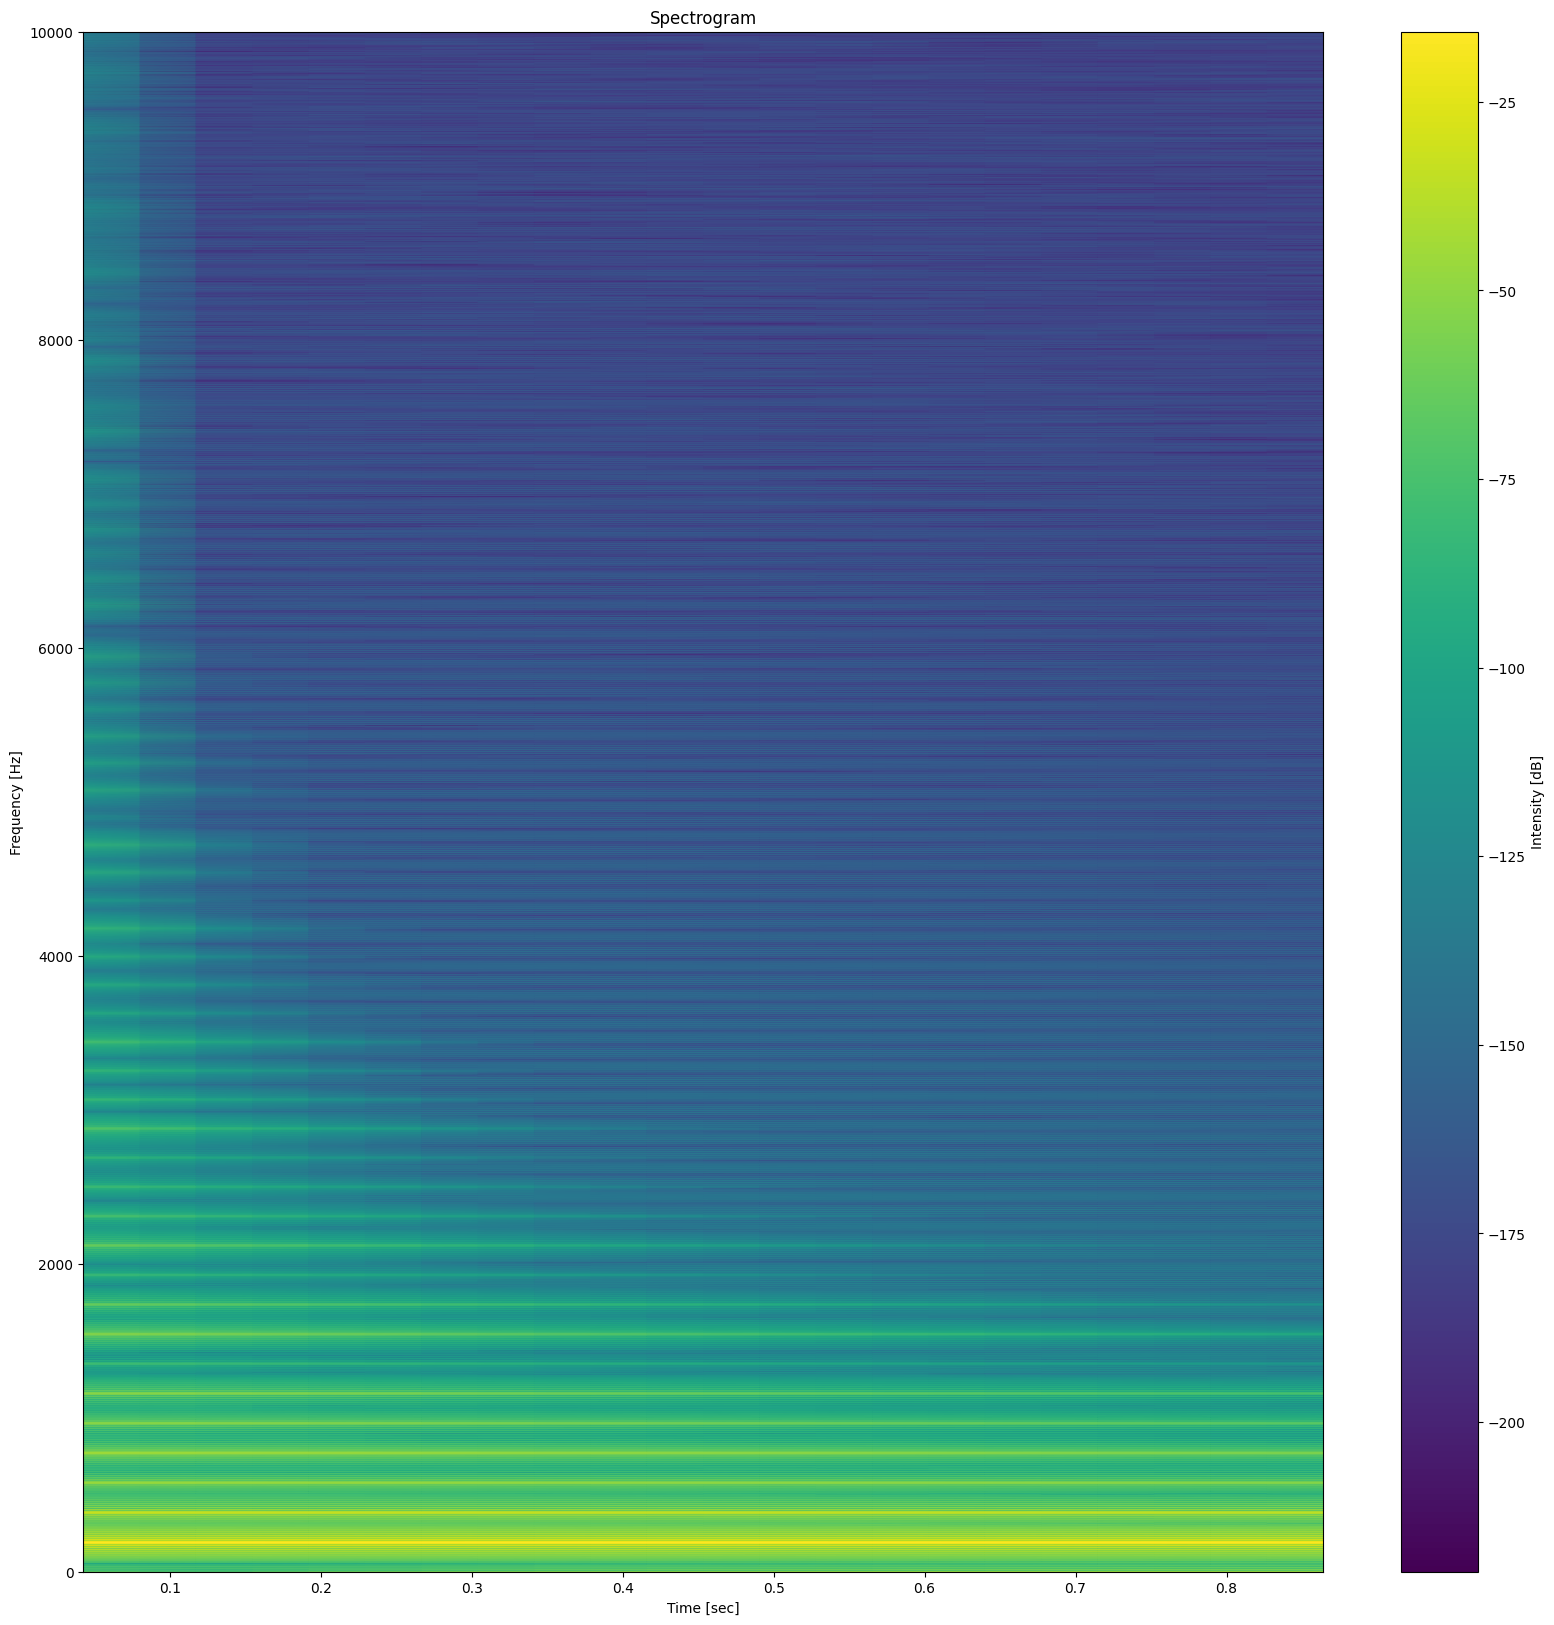

Estimated fundamental frequency: 193.359375 Hz


In [3]:
audio = np.array(
    [position[42] for position in output.positions],
    dtype=np.float32,
)
from IPython.display import Audio


# show spectrogram
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

# downsample audio for better visualization
from scipy.signal import resample_poly

audio = resample_poly(audio, up=1, down=16)

# normalize audio
audio = audio / np.max(np.abs(audio))

fs = 24000

display(Audio(audio, rate=fs))

audio = audio[:22000]

# show spectrogram
frequencies, times, Sxx = spectrogram(
    audio, fs=fs, nperseg=2048, noverlap=None, nfft=16384
)
# width=512, noverlap=256)
plt.figure(figsize=(20, 20))
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading="gouraud")
plt.ylabel("Frequency [Hz]")
plt.xlabel("Time [sec]")
plt.title("Spectrogram")
plt.colorbar(label="Intensity [dB]")
plt.ylim(0, 10000)  # limit y axis to 2000 Hz
plt.show()

# calculate fundamental frequency from spectrogram
import numpy as np

fundamental_freq = frequencies[np.argmax(Sxx, axis=0)]
print("Estimated fundamental frequency:", np.median(fundamental_freq), "Hz")

# create sin wave at fundamental frequency
t = np.linspace(0, len(audio) / fs, len(audio))
sine_wave = 0.05 * np.sin(2 * np.pi * np.median(fundamental_freq) * t)
# play sine wave
from IPython.display import display

display(Audio(sine_wave, rate=fs))


::: {.content-hidden}
# HIDDEN: Article END
:::

::: {.content-hidden}
# This entire markdown section will be hidden.
:::

In [4]:
# | echo: false
# | output: false
print("This code and its output will be hidden.")

This code and its output will be hidden.
